AVOID FALSE POSITIVE - MAXIMIZE PRECISION 
- False Positive: a negative or neutral tweet is classified as positive and company invests in promoting something that customers view negatively
    - False Positive is worse of the two because it leads to negative customer experience, lower NPS, and brand suffers in longer term. Basically spending money for customer to have negative experience.
- False Negative: a positive tweet is classified as negative, and company misses opportunity to invest in promoting something that customers view positively

### Note: Add Cross Val in Models
### Next steps:
- pre-trained embeddings / sentiment analysis : revisit Word2Vec/Glove
- clustering (grouping tweets)
- if want to revisit more feat eng - can go back to if there is reply/rt/hashtags

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix, precision_score, f1_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


import re
import nltk
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer


In [5]:
# import file
df = pd.read_csv('../data/judge-1377884607_tweet_product_company.csv', encoding= 'unicode_escape')

In [6]:
# Preview file 
df.head(10)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


In [7]:
# Overview file
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
tweet_text                                            9092 non-null object
emotion_in_tweet_is_directed_at                       3291 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9093 non-null object
dtypes: object(3)
memory usage: 213.2+ KB


In [8]:
# Value counts exploration
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [9]:
# Fill nulls
df['emotion_in_tweet_is_directed_at'].fillna('None', inplace=True)

In [10]:
# Recheck
df['emotion_in_tweet_is_directed_at'].value_counts()

None                               5802
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [11]:
df['brand_directed_at'] = df['emotion_in_tweet_is_directed_at'].map({'iPad': 'Apple',
                                                                    'Apple':'Apple',
                                                                    'iPad or iPhone App': 'Apple',
                                                                    'Google': 'Google', 
                                                                    'iPhone':'Apple',
                                                                    'Other Google product or service': 'Google',
                                                                    'Android App': 'Google', 
                                                                    'Android': 'Google',
                                                                    'Other Apple product or service':'Apple',
                                                                    'None':'None'})

In [12]:
df['num_brand_directed_at'] = df['brand_directed_at'].map({'None': 0,
                                                           'Apple': 1,
                                                           'Google': 2})

In [13]:
df['type_directed_at'] = df['emotion_in_tweet_is_directed_at'].map({'iPad': 'Product',
                                                                    'Apple':'Brand',
                                                                    'iPad or iPhone App': 'App',
                                                                    'Google': 'Brand', 
                                                                    'iPhone':'Product',
                                                                    'Other Google product or service': 'Service',
                                                                    'Android App': 'App', 
                                                                    'Android': 'Product',
                                                                    'Other Apple product or service':'Service',
                                                                    'None':'None'})

In [14]:
df['type_directed_at'].value_counts()

None       5802
Product    1321
Brand      1091
App         551
Service     328
Name: type_directed_at, dtype: int64

In [15]:
df['num_type_directed_at'] = df['type_directed_at'].map({'None': 0,
                                                         'Product': 1,
                                                         'Brand': 2,
                                                         'App': 3,
                                                         'Service': 4})

In [16]:
# Value counts exploration
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [17]:
# Filter down emotions to Neutral
df['is_there_an_emotion_directed_at_a_brand_or_product'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].map({"No emotion toward brand or product" : "Neutral",
                                                                                                                         "Positive emotion": "Positive",
                                                                                                                         "Negative emotion": "Negative",
                                                                                                                         "I can't tell": "Neutral"})

In [18]:
# 67/33 split (33% positive), class imbalacne
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

Neutral     5545
Positive    2978
Negative     570
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [19]:
# Create target; Positive only - 32%
df['target'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].map({"Positive": 1,
                                                                             "Neutral": 0,
                                                                             "Negative": 0})

In [20]:
# Check work
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand_directed_at,num_brand_directed_at,type_directed_at,num_type_directed_at,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,Apple,1,Product,1,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Apple,1,App,3,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Apple,1,Product,1,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,Apple,1,App,3,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,Google,2,Brand,2,1


In [21]:
df.isnull().sum()

tweet_text                                            1
emotion_in_tweet_is_directed_at                       0
is_there_an_emotion_directed_at_a_brand_or_product    0
brand_directed_at                                     0
num_brand_directed_at                                 0
type_directed_at                                      0
num_type_directed_at                                  0
target                                                0
dtype: int64

In [22]:
df[df['tweet_text'].isnull()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand_directed_at,num_brand_directed_at,type_directed_at,num_type_directed_at,target
6,NaN,None,Neutral,None,0,None,0,0


In [23]:
# drop row 6
df.drop(labels=6, axis=0, inplace=True)

In [24]:
# reset index post drop
df = df.reset_index(drop=True)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9092 entries, 0 to 9091
Data columns (total 8 columns):
tweet_text                                            9092 non-null object
emotion_in_tweet_is_directed_at                       9092 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9092 non-null object
brand_directed_at                                     9092 non-null object
num_brand_directed_at                                 9092 non-null int64
type_directed_at                                      9092 non-null object
num_type_directed_at                                  9092 non-null int64
target                                                9092 non-null int64
dtypes: int64(3), object(5)
memory usage: 568.4+ KB


#### Processing

- remove URLs, Mentions, HTML, punctuation
- lower case

In [26]:
# Tweet preprocessor test
# Source: https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e
import preprocessor as p

In [27]:
p.clean(df['tweet_text'][0])

'. I have a G iPhone. After hrs tweeting at , it was dead! I need to upgrade. Plugin stations at .'

In [28]:
# Create new column for cleaned text - remove URLs, Mentions
df['clean_text'] = df['tweet_text'].apply(lambda x: p.clean(x))

# Lower case
df['clean_text'] = df['clean_text'].str.lower()

In [29]:
# Preview new 
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand_directed_at,num_brand_directed_at,type_directed_at,num_type_directed_at,target,clean_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,Apple,1,Product,1,0,". i have a g iphone. after hrs tweeting at , i..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Apple,1,App,3,1,know about ? awesome ipad/iphone app that you'...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Apple,1,Product,1,1,can not wait for also. they should sale them d...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,Apple,1,App,3,0,i hope this year's festival isn't as crashy as...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,Google,2,Brand,2,1,"great stuff on fri : marissa mayer (google), t..."


In [44]:
# Pull tweet with HTML &quot;
df['tweet_text'][9090]

'Some Verizon iPhone customers complained their time fell back an hour this weekend.  Of course they were the New Yorkers who attended #SXSW.'

In [31]:
# Test cleaning
html_ent_clean = re.compile('&.*?;')
re.sub(html_ent_clean, '', df['clean_text'][9090])

'some verizon iphone customers complained their time fell back an hour this weekend. of course they were the new yorkers who attended .'

In [32]:
# Clean 'clean_text' column of HTML
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(html_ent_clean, '',x))

In [33]:
# Check work
len(df[df['clean_text'].str.contains(html_ent_clean) == True])

0

In [34]:
# Remove punctuation
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(r'[^\w\s]', '', (x)))

In [35]:
# Check work 
df['clean_text'][9090]

'some verizon iphone customers complained their time fell back an hour this weekend of course they were the new yorkers who attended '

#### Remove stopwords

In [36]:
twitter_ops = ['mention', 'rt', 'link', 'via'] # Twitter operational words not valueable, remove
stop_words = stopwords.words('english') + list(string.punctuation) + twitter_ops

In [37]:
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join(
    [word for word in x.split() if word.lower() not in (stop_words)]))

In [38]:
df['clean_text']

0       g iphone hrs tweeting dead need upgrade plugin...
1       know awesome ipadiphone app youll likely appre...
2                                          wait also sale
3        hope years festival isnt crashy years iphone app
4       great stuff fri marissa mayer google tim oreil...
                              ...                        
9087                                      ipad everywhere
9088    wave buzz interrupt regularly scheduled geek p...
9089    googles zeiger physician never reported potent...
9090    verizon iphone customers complained time fell ...
9091                    ___rt google tests checkin offers
Name: clean_text, Length: 9092, dtype: object

#### Tokenize

In [39]:
# Tokenize
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

df['clean_text'] = df['clean_text'].apply(lambda x: nltk.regexp_tokenize(x, pattern))

In [40]:
# Preview
df['clean_text']

0       [g, iphone, hrs, tweeting, dead, need, upgrade...
1       [know, awesome, ipadiphone, app, youll, likely...
2                                      [wait, also, sale]
3       [hope, years, festival, isnt, crashy, years, i...
4       [great, stuff, fri, marissa, mayer, google, ti...
                              ...                        
9087                                   [ipad, everywhere]
9088    [wave, buzz, interrupt, regularly, scheduled, ...
9089    [googles, zeiger, physician, never, reported, ...
9090    [verizon, iphone, customers, complained, time,...
9091                 [rt, google, tests, checkin, offers]
Name: clean_text, Length: 9092, dtype: object

#### Lemmatization

In [ ]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

df['clean_text'] = df['clean_text'].apply(lemmatize_text)
# Source: https://stackoverflow.com/questions/59567357/lemmatize-tokenised-column-in-pandas

In [ ]:
df['clean_text']

In [ ]:
# Rejoin
df['clean_text'] = df['clean_text'].map(lambda x: ' '.join(x))

In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9092 entries, 0 to 9091
Data columns (total 9 columns):
tweet_text                                            9092 non-null object
emotion_in_tweet_is_directed_at                       9092 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9092 non-null object
brand_directed_at                                     9092 non-null object
num_brand_directed_at                                 9092 non-null int64
type_directed_at                                      9092 non-null object
num_type_directed_at                                  9092 non-null int64
target                                                9092 non-null int64
clean_text                                            9092 non-null object
dtypes: int64(3), object(6)
memory usage: 639.4+ KB


In [218]:
# Average number of words in clean_text
num_words = df.clean_text.apply(lambda x: len(x.split()))
num_words.mean()

8.519247690277167

In [219]:
# samples/words-per-sample ratio
9092/9.14
# <1500 This means that we will create a MLP model.
# Source: https://developers.google.com/machine-learning/guides/text-classification/step-2-5

994.7483588621444

### Baseline Model -  tweet text only

In [47]:
# Grabbing our inputs and target
X = df['clean_text']
y = df['target']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [48]:
X_train.shape

(6819,)

In [49]:
# LB
def classify_vectorized_text(vectorizer, classifier, X_train, X_test, y_train, y_test):
    '''
    Fit and transform text data using the provided vectorizer, then fit and 
    predict with the provided classifier, in order to see the resulting
    accuracy score and confusion matrix
    For the Xtrain, Xtest, ytrain, ytest, expect the output of an
    sklearn train/test split
    -
    Inputs:
    vectorizer: an instantiated sklearn vectorizer
    classifier: an instantiated sklearn classifier
    X_train: training input data
    X_test: testing input data
    y_train: training true result
    y_test: testing true result
    -
    Outputs: 
    train_preds: predicted results for the train set
    test_preds: predicted results for the test set
    '''

    X_train_transformed = vectorizer.fit_transform(X_train) #learning corpus of training data (holistic)
    X_test_transformed = vectorizer.transform(X_test) # new words only in test set won't impact

    classifier.fit(X_train_transformed, y_train)

    train_preds = classifier.predict(X_train_transformed)
    test_preds = classifier.predict(X_test_transformed)

    print(f'Accuracy:{accuracy_score(y_test, test_preds)}')
    print(f'Precision:{precision_score(y_test, test_preds)}')
    print(f'F1 Score:{f1_score(y_test, test_preds)}')
    plot_confusion_matrix(classifier, X_test_transformed, y_test,
                          values_format=".4g")  # to make numbers readable
    plt.show()

    return(train_preds, test_preds)

#### NB + CountVec

In [50]:
# Instantiating a count vectorizer
countvec = CountVectorizer()

Accuracy:0.7069951605807303
Precision:0.5766192733017378
F1 Score:0.5229226361031519


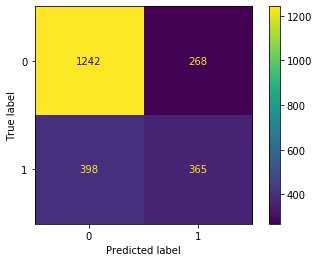

(array([0, 1, 1, ..., 1, 1, 0]), array([0, 0, 1, ..., 1, 0, 0]))

In [51]:
# Trying Naive Bayes
nb = MultinomialNB()

classify_vectorized_text(countvec, nb, X_train, X_test, y_train, y_test)
#0.58 precision score

#### NB + TF-IDF

In [52]:
# Instantiating the TF-IDF vectorizer
tfidf = TfidfVectorizer(max_df = .95, # removes words that appear in more than 95% of docs
                        min_df = 2, # removes words that appear 2 or fewer times
                        use_idf=True)

# Training on the train set, then transforming the train set
tfidf_train = tfidf.fit_transform(X_train)
# Transforming the test set
tfidf_test = tfidf.transform(X_test)

Accuracy:0.7109546854377474
Precision:0.6977611940298507
F1 Score:0.3627546071774976


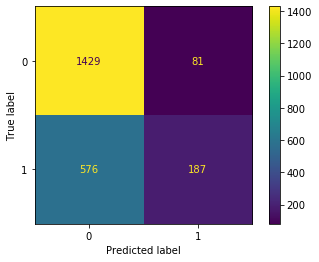

(array([0, 0, 0, ..., 0, 1, 0]), array([0, 0, 1, ..., 0, 0, 0]))

In [53]:
# More Naive Bayes, but with tfidf
nb_tfidf = MultinomialNB()

classify_vectorized_text(tfidf, nb_tfidf, X_train, X_test, y_train, y_test)
# Precision up by 0.12 - significant
# Accuracy also higher
# F1 down by .2 meaning recall is meaningfully lower

#### RF + TF-IDF

Accuracy:0.7175538935327761
Precision:0.598694942903752
F1 Score:0.5334302325581396


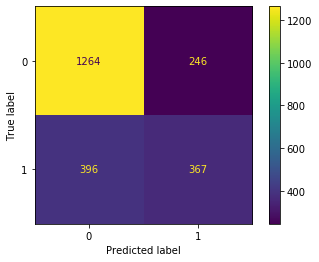

(array([0, 0, 1, ..., 1, 1, 0]), array([0, 0, 0, ..., 1, 0, 1]))

In [54]:
# Try RandomForest with class balance (not used in previous models)
rfc = RandomForestClassifier(class_weight='balanced')

classify_vectorized_text(tfidf, rfc, X_train, X_test, y_train, y_test)
# Precision lower

## Model with additional features
- Also possible to add in feat eng from notebook 1 - replies, rts, mentions, etc
- Apple/Google feat
- tuning/gridsearch/boosting RF if that is model of choice

Further ideas:
- explore pre-trained embeddings (sentiments) 
- clustering (grouping tweets)

In [55]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand_directed_at,num_brand_directed_at,type_directed_at,num_type_directed_at,target,clean_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,Apple,1,Product,1,0,g iphone hr tweeting dead need upgrade plugin ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Apple,1,App,3,1,know awesome ipadiphone app youll likely appre...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Apple,1,Product,1,1,wait also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,Apple,1,App,3,0,hope year festival isnt crashy year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,Google,2,Brand,2,1,great stuff fri marissa mayer google tim oreil...


### Model 2 set up

In [56]:
df.columns

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product',
       'brand_directed_at', 'num_brand_directed_at', 'type_directed_at',
       'num_type_directed_at', 'target', 'clean_text'],
      dtype='object')

In [57]:
df.shape

(9092, 9)

In [58]:
df.isna().sum()

tweet_text                                            0
emotion_in_tweet_is_directed_at                       0
is_there_an_emotion_directed_at_a_brand_or_product    0
brand_directed_at                                     0
num_brand_directed_at                                 0
type_directed_at                                      0
num_type_directed_at                                  0
target                                                0
clean_text                                            0
dtype: int64

In [59]:
# Grabbing our inputs and target
X = df[['clean_text', 'num_brand_directed_at', 'num_type_directed_at']]
y = df['target']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Count Vec - Can delete this post figuring out TF-IDF version

In [60]:
# Instantiating a count vectorizer; putting 2 just because instantiating new instance
# no change from previous countvec
countvec2 = CountVectorizer()

In [61]:
X_train_transformed = countvec2.fit_transform(X_train['clean_text'])
X_test_transformed = countvec2.transform(X_test['clean_text'])

In [62]:
# Create X_train with appended columns
# X_train text vectorizing
X_train_vect_text_df = pd.DataFrame(X_train_transformed.toarray(), columns=countvec2.get_feature_names())

In [63]:
X_train_vect_text_df.head()

,aapl,aaron,ab,abandoned,abba,abc,aber,ability,able,abnormal,...,zlf,zms,zombie,zomg,zone,zoom,zuckerberg,zuckerberglink,zynga,zzzs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
X_train_vect_text_df.shape

(6819, 6974)

In [65]:
# Append emotion in tweet directed at to vectorized X_train clean text
X_train_full = pd.merge(left=X_train_vect_text_df, right=X[['num_brand_directed_at', 'num_type_directed_at']],
                        how='left', left_index=True, right_index=True)

In [66]:
X_train_full.shape

(6819, 6976)

In [67]:
y_train.shape

(6819,)

In [68]:
# Create X_test with appended columns
X_test_vect_text_df = pd.DataFrame(X_test_transformed.toarray(), columns=countvec2.get_feature_names())

In [69]:
# Append emotion in tweet directed at
X_test_full = pd.concat([X[['num_brand_directed_at', 'num_type_directed_at']], X_test_vect_text_df], axis=1, join='inner')

In [70]:
#Preview
X_test_full.shape

(2273, 6976)

In [71]:
X_test_full.head()

,num_brand_directed_at,num_type_directed_at,aapl,aaron,ab,abandoned,abba,abc,aber,ability,...,zlf,zms,zombie,zomg,zone,zoom,zuckerberg,zuckerberglink,zynga,zzzs
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
nb = MultinomialNB()
nb.fit(X_train_full, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Accuracy:0.45886493620765506
Precision:0.3365990202939118
F1 Score:0.4388686131386861


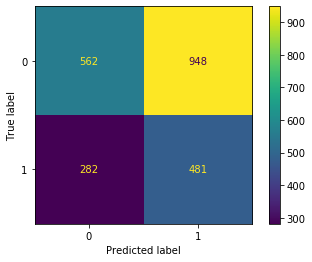

In [73]:
train_preds = nb.predict(X_train_full)
test_preds = nb.predict(X_test_full)

print(f'Accuracy:{accuracy_score(y_test, test_preds)}')
print(f'Precision:{precision_score(y_test, test_preds)}')
print(f'F1 Score:{f1_score(y_test, test_preds)}')
plot_confusion_matrix(nb, X_test_full, y_test,
                      values_format=".4g")  # to make numbers readable
plt.show()

### TF-IDF Version

In [74]:
# Instantiating the TF-IDF vectorizer; labeled as 2 to differentiate instance
tfidf2 = TfidfVectorizer(max_df = .95, # removes words that appear in more than 95% of docs
                        min_df = 2, # removes words that appear 2 or fewer times
                        use_idf=True)

In [75]:
X_train_transformed = tfidf2.fit_transform(X_train['clean_text'])
X_test_transformed = tfidf2.transform(X_test['clean_text'])

In [76]:
# Create X_train with appended columns
# X_train text vectorizing
X_train_tfidfvect_text_df = pd.DataFrame(X_train_transformed.toarray(), columns=tfidf2.get_feature_names())

In [77]:
X_train_tfidfvect_text_df.head()

,aapl,ab,abc,ability,able,absolutely,absolutley,abt,academy,acc,...,zazzle,zinio,zip,zms,zombie,zomg,zone,zoom,zuckerberg,zynga
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
X_train_tfidfvect_text_df.shape

(6819, 3709)

In [79]:
# Append emotion in tweet directed at to vectorized X_train clean text
X_train_full = pd.merge(left=X_train_tfidfvect_text_df, right=X[['num_brand_directed_at', 'num_type_directed_at']],
                        how='left', left_index=True, right_index=True)

In [80]:
X_train_full.shape

(6819, 3711)

In [81]:
y_train.shape

(6819,)

In [82]:
# Create X_test with appended columns
X_test_tfidfvect_text_df = pd.DataFrame(X_test_transformed.toarray(), columns=tfidf2.get_feature_names())

In [83]:
# Append emotion in tweet directed at
X_test_full = pd.concat([X[['num_brand_directed_at', 'num_type_directed_at']], 
                        X_test_tfidfvect_text_df], axis=1, join='inner')

In [84]:
#Preview
X_test_full.shape

(2273, 3711)

In [85]:
X_test_full.head()

,num_brand_directed_at,num_type_directed_at,aapl,ab,abc,ability,able,absolutely,absolutley,abt,...,zazzle,zinio,zip,zms,zombie,zomg,zone,zoom,zuckerberg,zynga
0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
nb = MultinomialNB()
nb.fit(X_train_full, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Accuracy:0.6106467223933129
Precision:0.387037037037037
F1 Score:0.3207981580966999


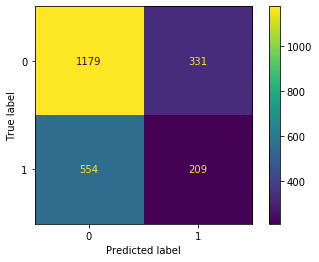

In [87]:
train_preds = nb.predict(X_train_full)
test_preds = nb.predict(X_test_full)

print(f'Accuracy:{accuracy_score(y_test, test_preds)}')
print(f'Precision:{precision_score(y_test, test_preds)}')
print(f'F1 Score:{f1_score(y_test, test_preds)}')
plot_confusion_matrix(nb, X_test_full, y_test,
                      values_format=".4g")  # to make numbers readable
plt.show()

## Data Reformat
- brand 0-2 and type (product/app/service) 0-3 convert to 0-1 columns

In [88]:
df.columns

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product',
       'brand_directed_at', 'num_brand_directed_at', 'type_directed_at',
       'num_type_directed_at', 'target', 'clean_text'],
      dtype='object')

In [89]:
df['brand_directed_at'].unique()

array(['Apple', 'Google', 'None'], dtype=object)

In [90]:
df['tweet_brand_Apple'] = 0
df['tweet_brand_Google'] = 0

for row in df['brand_directed_at'].index:
    if df['brand_directed_at'][row] == 'Apple':
        df['tweet_brand_Apple'][row] = 1
    elif df['brand_directed_at'][row] == 'Google':
        df['tweet_brand_Google'][row] = 1

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [91]:
df['type_directed_at'].unique()

array(['Product', 'App', 'Brand', 'None', 'Service'], dtype=object)

In [92]:
df['tweet_type_product'] = 0
df['tweet_type_app'] = 0
df['tweet_type_brand'] = 0
df['tweet_type_service'] = 0

for row in df['type_directed_at'].index:
    if df['type_directed_at'][row] == 'Product':
        df['tweet_type_product'][row] = 1
    if df['type_directed_at'][row] == 'App':
        df['tweet_type_app'][row] = 1
    if df['type_directed_at'][row] == 'Brand':
        df['tweet_type_brand'][row] = 1
    elif df['type_directed_at'][row] == 'Service':
        df['tweet_type_service'][row] = 1

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9092 entries, 0 to 9091
Data columns (total 15 columns):
tweet_text                                            9092 non-null object
emotion_in_tweet_is_directed_at                       9092 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9092 non-null object
brand_directed_at                                     9092 non-null object
num_brand_directed_at                                 9092 non-null int64
type_directed_at                                      9092 non-null object
num_type_directed_at                                  9092 non-null int64
target                                                9092 non-null int64
clean_text                                            9092 non-null object
tweet_brand_Apple                                     9092 non-null int64
tweet_brand_Google                                    9092 non-null int64
tweet_type_product                                    9092 non-null int64

In [94]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand_directed_at,num_brand_directed_at,type_directed_at,num_type_directed_at,target,clean_text,tweet_brand_Apple,tweet_brand_Google,tweet_type_product,tweet_type_app,tweet_type_brand,tweet_type_service
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,Apple,1,Product,1,0,g iphone hr tweeting dead need upgrade plugin ...,1,0,1,0,0,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Apple,1,App,3,1,know awesome ipadiphone app youll likely appre...,1,0,0,1,0,0
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Apple,1,Product,1,1,wait also sale,1,0,1,0,0,0
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,Apple,1,App,3,0,hope year festival isnt crashy year iphone app,1,0,0,1,0,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,Google,2,Brand,2,1,great stuff fri marissa mayer google tim oreil...,0,1,0,0,1,0


In [95]:
NB_df = df.drop(columns=['tweet_text', 'emotion_in_tweet_is_directed_at',
               'is_there_an_emotion_directed_at_a_brand_or_product',
                'brand_directed_at', 'num_brand_directed_at',
                'type_directed_at', 'num_type_directed_at'], axis=1)

In [96]:
NB_df.head()

,target,clean_text,tweet_brand_Apple,tweet_brand_Google,tweet_type_product,tweet_type_app,tweet_type_brand,tweet_type_service
0,0,g iphone hr tweeting dead need upgrade plugin ...,1,0,1,0,0,0
1,1,know awesome ipadiphone app youll likely appre...,1,0,0,1,0,0
2,1,wait also sale,1,0,1,0,0,0
3,0,hope year festival isnt crashy year iphone app,1,0,0,1,0,0
4,1,great stuff fri marissa mayer google tim oreil...,0,1,0,0,1,0


### Reformatted Models - Count Vec - Can delete this post figuring out TF-IDF version

In [97]:
# Grabbing our inputs and target
X = NB_df.drop(columns='target', axis=1)
y = NB_df['target']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [98]:
X.columns

Index(['clean_text', 'tweet_brand_Apple', 'tweet_brand_Google',
       'tweet_type_product', 'tweet_type_app', 'tweet_type_brand',
       'tweet_type_service'],
      dtype='object')

In [99]:
# Instantiating a count vectorizer; putting 2 just because instantiating new instance
# no change from previous countvec
countvec3 = CountVectorizer()

In [100]:
X_train_transformed = countvec3.fit_transform(X_train['clean_text'])
X_test_transformed = countvec3.transform(X_test['clean_text'])

In [101]:
# Create X_train with appended columns
# X_train text vectorizing
X_train_vect_text_df = pd.DataFrame(X_train_transformed.toarray(), columns=countvec3.get_feature_names())

In [102]:
X_train_vect_text_df.head()

,aapl,aaron,ab,abandoned,abba,abc,aber,ability,able,abnormal,...,zlf,zms,zombie,zomg,zone,zoom,zuckerberg,zuckerberglink,zynga,zzzs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [103]:
X_train_vect_text_df.shape

(6819, 6974)

In [104]:
# Append emotion in tweet directed at to vectorized X_train clean text
X_train_full = pd.merge(left=X_train_vect_text_df, right=X.drop(columns='clean_text', axis=1),
                        how='left', left_index=True, right_index=True)

In [105]:
X_train_full.shape

(6819, 6980)

In [106]:
y_train.shape

(6819,)

In [107]:
# Create X_test with appended columns
X_test_vect_text_df = pd.DataFrame(X_test_transformed.toarray(), columns=countvec2.get_feature_names())

In [108]:
# Append emotion in tweet directed at
X_test_full = pd.concat([X.drop(columns='clean_text', axis=1), X_test_vect_text_df], axis=1, join='inner')

In [109]:
#Preview
X_test_full.shape

(2273, 6980)

In [110]:
X_test_full.head()

,tweet_brand_Apple,tweet_brand_Google,tweet_type_product,tweet_type_app,tweet_type_brand,tweet_type_service,aapl,aaron,ab,abandoned,...,zlf,zms,zombie,zomg,zone,zoom,zuckerberg,zuckerberglink,zynga,zzzs
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [111]:
nb = MultinomialNB()
nb.fit(X_train_full, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Accuracy:0.48262208534975803
Precision:0.3441509433962264
F1 Score:0.4367816091954023


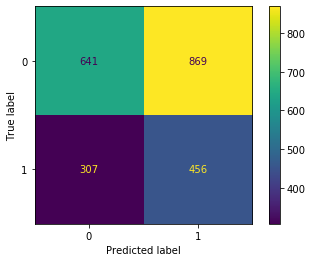

In [112]:
train_preds = nb.predict(X_train_full)
test_preds = nb.predict(X_test_full)

print(f'Accuracy:{accuracy_score(y_test, test_preds)}')
print(f'Precision:{precision_score(y_test, test_preds)}')
print(f'F1 Score:{f1_score(y_test, test_preds)}')
plot_confusion_matrix(nb, X_test_full, y_test,
                      values_format=".4g")  # to make numbers readable
plt.show()

### TF-IDF Version

In [113]:
# Instantiating the TF-IDF vectorizer; labeled as 2 to differentiate instance
tfidf3 = TfidfVectorizer(max_df = .95, # removes words that appear in more than 95% of docs
                        min_df = 2, # removes words that appear 2 or fewer times
                        use_idf=True)

In [114]:
X_train_transformed = tfidf3.fit_transform(X_train['clean_text'])
X_test_transformed = tfidf3.transform(X_test['clean_text'])

In [115]:
# Create X_train with appended columns
# X_train text vectorizing
X_train_tfidfvect_text_df = pd.DataFrame(X_train_transformed.toarray(), columns=tfidf3.get_feature_names())

In [116]:
X_train_tfidfvect_text_df.head()

,aapl,ab,abc,ability,able,absolutely,absolutley,abt,academy,acc,...,zazzle,zinio,zip,zms,zombie,zomg,zone,zoom,zuckerberg,zynga
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [117]:
X_train_tfidfvect_text_df.shape

(6819, 3709)

In [118]:
# Append emotion in tweet directed at to vectorized X_train clean text
X_train_full = pd.merge(left=X_train_tfidfvect_text_df, right=X.drop(columns='clean_text', axis=1),
                        how='left', left_index=True, right_index=True)

In [119]:
X_train_full.shape

(6819, 3715)

In [120]:
y_train.shape

(6819,)

In [121]:
# Create X_test with appended columns
X_test_tfidfvect_text_df = pd.DataFrame(X_test_transformed.toarray(), columns=tfidf3.get_feature_names())

In [122]:
# Append emotion in tweet directed at
X_test_full = pd.concat([X.drop(columns='clean_text', axis=1), 
                        X_test_tfidfvect_text_df], axis=1, join='inner')

In [123]:
#Preview
X_test_full.shape

(2273, 3715)

In [124]:
X_test_full.head()

,tweet_brand_Apple,tweet_brand_Google,tweet_type_product,tweet_type_app,tweet_type_brand,tweet_type_service,aapl,ab,abc,ability,...,zazzle,zinio,zip,zms,zombie,zomg,zone,zoom,zuckerberg,zynga
0,1,0,1,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,1,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,1,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,0,1,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1,0,0,1,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [125]:
nb = MultinomialNB()
nb.fit(X_train_full, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Accuracy:0.5741311042674879
Precision:0.34108527131782945
F1 Score:0.31249999999999994


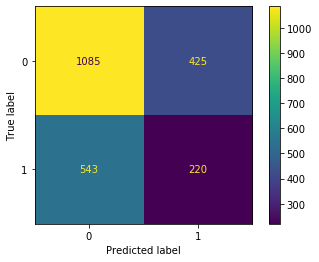

In [126]:
train_preds = nb.predict(X_train_full)
test_preds = nb.predict(X_test_full)

print(f'Accuracy:{accuracy_score(y_test, test_preds)}')
print(f'Precision:{precision_score(y_test, test_preds)}')
print(f'F1 Score:{f1_score(y_test, test_preds)}')
plot_confusion_matrix(nb, X_test_full, y_test,
                      values_format=".4g")  # to make numbers readable
plt.show()

## RF?

In [127]:
# Try RandomForest with class balance (not used in previous models)
rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(X_train_full, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Accuracy:0.6608007039155301
Precision:0.3888888888888889
F1 Score:0.035043804755944936


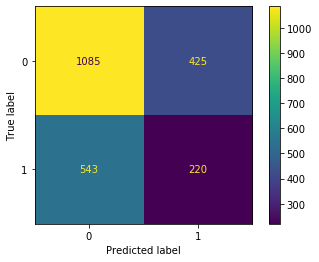

In [128]:
train_preds = rfc.predict(X_train_full)
test_preds = rfc.predict(X_test_full)

print(f'Accuracy:{accuracy_score(y_test, test_preds)}')
print(f'Precision:{precision_score(y_test, test_preds)}')
print(f'F1 Score:{f1_score(y_test, test_preds)}')
plot_confusion_matrix(nb, X_test_full, y_test,
                      values_format=".4g")  # to make numbers readable
plt.show()

### Word2Vec

In [134]:
from gensim.models import Word2Vec
from nltk import word_tokenize
import nltk

In [135]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/amandagaeta/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [131]:
df['tweet_text']

0       .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also. The...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW: Marissa M...
                              ...                        
9087                        Ipad everywhere. #SXSW {link}
9088    Wave, buzz... RT @mention We interrupt your re...
9089    Google's Zeiger, a physician never reported po...
9090    Some Verizon iPhone customers complained their...
9091    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: tweet_text, Length: 9092, dtype: object

In [138]:
data_no_punc = df['tweet_text'].apply(lambda x: re.sub(r'[^\w\s]', '', (x)))

In [141]:
data_tokenized = data_no_punc.astype('str').map(word_tokenize)

In [142]:
data_tokenized[:5]

0    [wesley83, I, have, a, 3G, iPhone, After, 3, h...
1    [jessedee, Know, about, fludapp, Awesome, iPad...
2    [swonderlin, Can, not, wait, for, iPad, 2, als...
3    [sxsw, I, hope, this, years, festival, isnt, a...
4    [sxtxstate, great, stuff, on, Fri, SXSW, Maris...
Name: tweet_text, dtype: object

In [144]:
model = Word2Vec(data, vector_size=100, window=5, min_count=1, workers=4)

In [145]:
model.train(data, total_examples=model.corpus_count, epochs=10)

(1425027, 2218320)

In [146]:
wv = model.wv

In [149]:
wv.most_similar('sxsw')

[('SXSW', 0.789685070514679),
 ('SxSW', 0.752503514289856),
 ('uncategorized', 0.6480029821395874),
 ('cbs', 0.6120305061340332),
 ('randomactofkindness', 0.6114920973777771),
 ('designflaws', 0.5963109135627747),
 ('widfy', 0.5957539677619934),
 ('edapps', 0.5851917266845703),
 ('concerts', 0.5820796489715576),
 ('so..debuting', 0.5789573192596436)]

#### Try again

In [152]:
model2 = Word2Vec(data, vector_size=100, window=2, min_count=450 , workers=4) 
# min count is 5% of total records
# window 2 because tweets are short

In [153]:
model2.train(data, total_examples=model.corpus_count, epochs=10)

(363758, 2218320)

In [154]:
wv2 = model2.wv

In [155]:
wv2.most_similar('sxsw')

[('SXSW', 0.8534931540489197),
 ('it', 0.32851678133010864),
 ('and', 0.3047853708267212),
 ('...', 0.29774436354637146),
 ('on', 0.2849596440792084),
 ('new', 0.2756124436855316),
 ('you', 0.2630952298641205),
 ('that', 0.249092236161232),
 ("n't", 0.24382586777210236),
 ('.', 0.24077098071575165)]

#### Try again with clean_text

In [ ]:
# need to get clean-text back to tokenized version
# you reran the top through tokenization then ran this

In [334]:
model3 = Word2Vec(df['clean_text'], vector_size=100, window=5, min_count=1, workers=4)

In [335]:
model3.train(df['clean_text'], total_examples=model.corpus_count, epochs=10)

(657336, 774570)

In [336]:
wv3 = model3.wv

In [341]:
wv3.most_similar('google')

[('googles', 0.8908447623252869),
 ('ht', 0.8862664103507996),
 ('integrated', 0.8855570554733276),
 ('engines', 0.8805169463157654),
 ('linking', 0.8790125250816345),
 ('wary', 0.8756849765777588),
 ('averages', 0.8728684782981873),
 ('chatter', 0.8725588917732239),
 ('publicly', 0.8715401291847229),
 ('presented', 0.8694307804107666)]

In [347]:
wv3.most_similar('atx')

[('temporary', 0.9836650490760803),
 ('downtown', 0.9728882908821106),
 ('opening', 0.9710062742233276),
 ('temp', 0.962662935256958),
 ('sell', 0.9533684849739075),
 ('sets', 0.9513949155807495),
 ('dt', 0.949607253074646),
 ('earbuds', 0.9453362226486206),
 ('near', 0.9447932839393616),
 ('theyll', 0.9428122639656067)]

#### More epochs

In [350]:
model4 = Word2Vec(df['clean_text'], vector_size=100, window=5, min_count=1, workers=4, epochs=25)

In [352]:
model4.train(df['clean_text'], total_examples=model.corpus_count, epochs=10)

(657336, 774570)

In [353]:
wv4 = model4.wv

In [354]:
wv4.most_similar('google')

[('googles', 0.701808750629425),
 ('privacy', 0.5899797081947327),
 ('overthere', 0.5784167647361755),
 ('interested', 0.5727440118789673),
 ('joint', 0.5705278515815735),
 ('announcing', 0.565869152545929),
 ('thunder', 0.5540748238563538),
 ('penney', 0.5531365871429443),
 ('euphoria', 0.5488601326942444),
 ('competing', 0.5458197593688965)]

In [355]:
wv4.most_similar('apple')

[('apples', 0.7107737064361572),
 ('near', 0.6490306854248047),
 ('thcongress', 0.6468674540519714),
 ('hawk', 0.6355769634246826),
 ('influencerhipsters', 0.6253543496131897),
 ('bother', 0.6244949698448181),
 ('naomi', 0.6214144825935364),
 ('employees', 0.618522047996521),
 ('sell', 0.616887629032135),
 ('golds', 0.6154829859733582)]

In [356]:
wv4.most_similar('sxsw')

[('cars', 0.5629299283027649),
 ('audi', 0.5485613346099854),
 ('storethe', 0.5356596112251282),
 ('ipaded', 0.5292361378669739),
 ('shows', 0.5267095565795898),
 ('fridaythe', 0.5251169800758362),
 ('bizgym', 0.5241237282752991),
 ('sxsws', 0.5201442241668701),
 ('closes', 0.5048100352287292),
 ('welcome', 0.4991130232810974)]

In [362]:
wv4.most_similar('atx')

[('relinquish', 0.796271026134491),
 ('temporary', 0.7684605121612549),
 ('temporarily', 0.7678585052490234),
 ('bajillions', 0.766416609287262),
 ('temp', 0.757723331451416),
 ('nightapple', 0.7518656849861145),
 ('dt', 0.7511090636253357),
 ('downtown', 0.7384350895881653),
 ('international', 0.7307410836219788),
 ('slightly', 0.7240878939628601)]

In [ ]:
#### More Exploring
# Source: codealong
# https://flatiron.illumidesk.com/user/amandabgaeta/notebooks/dsc-classification-with-word-embeddings-codealong/index.ipynb

In [41]:
total_vocabulary_clean = set(word for tweet in df['clean_text'] for word in tweet)

In [42]:
total_vocabulary_clean

{'movies',
 'preferrably',
 'brought',
 'dorks',
 'a',
 'siggis',
 'departure',
 'conflict',
 'skiiers',
 'foot',
 'amy',
 'gourdoughs',
 'alarms',
 'swoon',
 'insanely',
 'holy',
 'feeback',
 'noobs',
 'blackberr',
 'selfserve',
 'saver',
 'buddy',
 'egyptian',
 'arsense',
 'jukebox',
 'upcoming',
 'overheating',
 'franco',
 'estate',
 'bounced',
 'matter',
 'jim',
 'smilebooth',
 'webmasters',
 'fees',
 'born',
 'wristbands',
 'initial',
 'smartest',
 'humpty',
 'anyone',
 'hiring',
 'grandfather',
 'gonna',
 'sim',
 'creativity',
 'peeingthis',
 'wilderness',
 'nextflix',
 'momi',
 'breaking',
 'disgusted',
 'amazes',
 'auto',
 'leh',
 'chat',
 'xbox',
 'air',
 'topics',
 'hoy',
 'charts',
 'seduce',
 'thousands',
 'parents',
 'ding',
 'small',
 'whore',
 'domain',
 'hurricane',
 'citymarket',
 'funnysad',
 'seo',
 'smut',
 'stereo',
 'powerhouse',
 'drafthouse',
 'carriers',
 'facts',
 'thewildernessdowntowncom',
 'pic',
 'barton',
 'austinjs',
 'route',
 'damn',
 'tristan',
 'calc

In [371]:
len(total_vocabulary_clean)
print('There are {} unique tokens in the dataset.'.format(len(total_vocabulary)))

There are 8660 unique tokens in the dataset.


In [377]:
import numpy as np

In [378]:
glove = {}
with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [384]:
glove['austin']

array([-0.88499 ,  0.73486 ,  0.42771 ,  0.53152 , -0.33275 , -0.69202 ,
       -1.3926  , -0.47548 ,  0.3105  , -0.35942 , -0.77389 , -0.088148,
       -0.49413 , -0.24575 ,  0.27501 ,  0.0267  , -0.19364 ,  0.053011,
       -0.19606 , -0.19697 , -0.22481 ,  0.61626 , -0.21885 ,  0.48354 ,
       -0.31253 , -0.82742 , -0.14236 , -0.50968 ,  0.09759 , -0.20696 ,
        1.3895  , -0.70472 , -0.17107 , -0.56504 ,  0.079604, -0.33617 ,
       -0.30254 , -0.15911 ,  0.80456 ,  0.11455 ,  0.22747 ,  0.56209 ,
       -0.19012 ,  0.22695 , -0.21445 ,  0.64895 ,  0.051276, -1.1333  ,
       -1.0925  ,  1.4248  ], dtype=float32)

In [385]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [387]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [388]:
rf =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Random Forest', RandomForestClassifier(n_estimators=100, verbose=True))])
svc = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('Support Vector Machine', SVC())])
lr = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Logistic Regression', LogisticRegression())])

In [389]:
models = [('Random Forest', rf),
          ('Support Vector Machine', svc),
          ('Logistic Regression', lr)]

In [390]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9092 entries, 0 to 9091
Data columns (total 9 columns):
tweet_text                                            9092 non-null object
emotion_in_tweet_is_directed_at                       9092 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9092 non-null object
brand_directed_at                                     9092 non-null object
num_brand_directed_at                                 9092 non-null int64
type_directed_at                                      9092 non-null object
num_type_directed_at                                  9092 non-null int64
target                                                9092 non-null int64
clean_text                                            9092 non-null object
dtypes: int64(3), object(6)
memory usage: 639.4+ KB


In [391]:
target = df['target']
data = df['tweet_text'].map(word_tokenize).values

In [393]:
scores = [(name, cross_val_score(model, data, target, cv=2).mean()) for name, model, in models]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [394]:
scores

[('Random Forest', 0.6930268367795864),
 ('Support Vector Machine', 0.6725692916849978),
 ('Logistic Regression', 0.6721293444786626)]